In [29]:
# import random
# import numpy as np
# import mesa


# def min_max_01(x: float) -> float:
#     return max(0.0, min(1.0, x))


# class Household(mesa.Agent):
#     """A household agent representing family environment."""
#     def __init__(self, model, family_support_level: float):
#         super().__init__(model)
#         self.family_support_level = family_support_level  # 0..1
#         self.issues = random.uniform(0, 1)               # 0..1


# class SchoolAgent(mesa.Agent):
#     """A school agent representing educational environment."""
#     def __init__(self, model, quality_level: float):
#         super().__init__(model)
#         self.quality_level = quality_level  # 0..1
#         self.resources = random.uniform(0, 1) # 0..1


# class YouthAgent(mesa.Agent):
#     """An agent representing a youth with risk propensity and peer influence."""
#     def __init__(self, model, age, neighbourhood_id, household, friend_group, school_status='enrolled'):
#         super().__init__(model)

#         self.age = age
#         self.neighbourhood_id = neighbourhood_id
#         self.household = household
#         self.friend_group = friend_group

#         # Individual traits / states
#         self.risk_propensity = random.uniform(0, 1)

#         # IMPORTANT: treat this as a latent inclination (0..1),
#         # not directly as the "commit crime this step" probability.
#         self.crime_involvement = random.uniform(0, 1)

#         self.school_status = school_status  # 'enrolled', 'at_risk', 'dropped_out', 'completed'
#         self.criminalrecord = 0

#         self.edu_performance = random.uniform(0, 1)
#         self.edu_motivation = random.uniform(0, 1)

#         self.family_support = self.household.family_support_level
#         self.issues_at_home = self.household.issues

#         self.job_chance = random.uniform(0, 1)
#         self.criminal_capital = random.uniform(0, 1)
#         self.job_status = random.choice(['unemployed', 'employed'])

#         # Inertia / memory (prevents instant dropout cascades)
#         self.dropout_risk_streak = 0

#         # Peer influence uses "recent offending" signal
#         self.last_offended = 0

#     def peer_stats(self):
#         friends = [a for a in self.friend_group if isinstance(a, YouthAgent)]
#         if not friends:
#             return 0.0, 0.0

#         peer_recent_crime = float(np.mean([f.last_offended for f in friends]))
#         peer_dropout_share = float(np.mean([1.0 if f.school_status == 'dropped_out' else 0.0 for f in friends]))
#         return peer_recent_crime, peer_dropout_share

#     def step(self):
#         p = self.model.params
#         peer_recent_crime, peer_dropout_share = self.peer_stats()

#         # -------------------------
#         # 1) Commit crime this step?
#         # -------------------------
#         # Small half-year hazard scaled by a simple risk index (few assumptions)
#         crime_risk = float(np.mean([
#             self.risk_propensity,
#             self.crime_involvement,
#             peer_recent_crime,
#             self.criminal_capital,
#             self.issues_at_home,
#             1.0 - self.family_support,
#             1.0 if self.school_status == 'dropped_out' else 0.0
#         ]))

#         p_offend = min_max_01(p["base_offend_halfyear"] * (0.5 + crime_risk))
#         offended = 1 if random.random() < p_offend else 0
#         self.last_offended = offended

#         if offended:
#             self.criminalrecord += 1
#             self.job_chance = min_max_01(self.job_chance - p["job_penalty_per_offense"])
#             self.crime_involvement = min_max_01(self.crime_involvement + p["crime_involvement_drift"])
#             self.criminal_capital = min_max_01(self.criminal_capital + p["criminal_capital_gain"])

#         # -------------------------
#         # 2) Education updates
#         # -------------------------
#         if self.school_status in ['enrolled', 'at_risk']:
#             # performance improves with motivation & support, drops with home issues & offending
#             self.edu_performance = min_max_01(
#                 self.edu_performance
#                 + p["perf_gain"] * self.edu_motivation
#                 + p["perf_gain"] * self.family_support
#                 - p["perf_loss"] * self.issues_at_home
#                 - p["perf_loss"] * offended
#             )

#             # motivation decreases with criminal capital, increases with job prospects & support
#             self.edu_motivation = min_max_01(
#                 self.edu_motivation
#                 - p["mot_loss"] * self.criminal_capital
#                 + p["mot_gain"] * self.job_chance
#                 + p["mot_gain"] * self.family_support
#             )

#             # criminal capital can still grow slowly with involvement even without offending every step
#             self.criminal_capital = min_max_01(self.criminal_capital + p["criminal_capital_drift"] * self.crime_involvement)

#         # -------------------------
#         # 3) Dropout (pushed + pulled) WITH inertia
#         # -------------------------
#         if self.school_status in ['enrolled', 'at_risk']:

#             # pushed-out risk: low perf/mot + home issues + peer dropout + low support
#             pushed_risk = float(np.mean([
#                 1.0 - self.edu_performance,
#                 1.0 - self.edu_motivation,
#                 self.issues_at_home,
#                 peer_dropout_share,
#                 1.0 - self.family_support
#             ]))

#             # pulled-out risk: criminal capital + peer crime/dropout norms
#             pulled_risk = float(np.mean([
#                 self.criminal_capital,
#                 peer_recent_crime,
#                 peer_dropout_share
#             ]))

#             total_dropout_risk = min_max_01(
#                 p["pushed_weight"] * pushed_risk +
#                 p["pulled_weight"] * pulled_risk
#             )

#             # Convert to a SMALL half-year hazard (this is the key stabilizer)
#             p_dropout = min_max_01(p["base_dropout_halfyear"] * (0.5 + total_dropout_risk))

#             # Optional: only allow dropout risk in typical school-age window (stabilizes realism)
#             if not (p["dropout_age_min"] <= self.age <= p["dropout_age_max"]):
#                 p_dropout = 0.0

#             # Inertia: need multiple risky steps
#             if random.random() < p_dropout:
#                 self.dropout_risk_streak += 1
#             else:
#                 self.dropout_risk_streak = max(0, self.dropout_risk_streak - 1)

#             if self.dropout_risk_streak >= p["streak_to_at_risk"]:
#                 self.school_status = 'at_risk'
#             if self.dropout_risk_streak >= p["streak_to_dropout"]:
#                 self.school_status = 'dropped_out'

#         # -------------------------
#         # 4) Completion & jobs
#         # -------------------------
#         if self.age > 17 and self.school_status == 'enrolled' and self.edu_performance >= p["completion_perf_threshold"]:
#             self.school_status = 'completed'
#             self.job_chance = min_max_01(self.job_chance + p["job_bonus_on_completion"])

#         if self.school_status == 'completed' and self.job_status == 'unemployed':
#             if random.random() < self.job_chance:
#                 self.job_status = 'employed'

#         # -------------------------
#         # 5) Age / exit
#         # -------------------------
#         self.age += 0.5  # each step = half a year
#         if self.age >= 24:
#             self.remove()
#             return


# class YouthCrimeModel(mesa.Model):
#     def __init__(self, N_initial, N_yearly):
#         super().__init__()
#         self.num_agents = N_initial
#         self.N_yearly = N_yearly

#         # Minimal, interpretable parameters (few knobs)
#         # If dropout is too high/low, change base_dropout_halfyear and/or streak_to_dropout first.
#         self.params = {
#             # Half-year hazards (your step is 0.5 years)
#             "base_dropout_halfyear": 0.02,   # ~ a few % per year for average-risk agents
#             "base_offend_halfyear": 0.06,

#             # Education dynamics (gentle drifts)
#             "perf_gain": 0.03,
#             "perf_loss": 0.03,
#             "mot_gain": 0.02,
#             "mot_loss": 0.02,

#             # Crime / work links
#             "job_penalty_per_offense": 0.01,
#             "crime_involvement_drift": 0.01,
#             "criminal_capital_gain": 0.02,
#             "criminal_capital_drift": 0.01,

#             # Dropout composition + inertia
#             "pushed_weight": 0.6,
#             "pulled_weight": 0.4,
#             "streak_to_at_risk": 2,
#             "streak_to_dropout": 4,

#             # Age window for dropout risk (optional, but helps realism)
#             "dropout_age_min": 12,
#             "dropout_age_max": 20,

#             # Completion
#             "completion_perf_threshold": 0.60,
#             "job_bonus_on_completion": 0.20,
#         }

#         self.datacollector = mesa.DataCollector(
#             model_reporters={
#                 "Average Crime Involvement": lambda m: np.mean([a.crime_involvement for a in m.agents if isinstance(a, YouthAgent)]),
#                 "Average Edu Motivation": lambda m: np.mean([a.edu_motivation for a in m.agents if isinstance(a, YouthAgent)]),
#                 "Average Edu Performance": lambda m: np.mean([a.edu_performance for a in m.agents if isinstance(a, YouthAgent)]),
#                 "Average Job Chance": lambda m: np.mean([a.job_chance for a in m.agents if isinstance(a, YouthAgent)]),
#                 "Drop out Rate": lambda m: np.mean([1 if a.school_status == 'dropped_out' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
#                 "Completed Rate": lambda m: np.mean([1 if a.school_status == 'completed' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
#             },
#             agent_reporters={
#                 "Age": lambda a: a.age if isinstance(a, YouthAgent) else None,
#                 "Crime Involvement": "crime_involvement",
#                 "Criminal record": "criminalrecord",
#                 "Edu Motivation": "edu_motivation",
#                 "Edu Performance": "edu_performance",
#                 "Job Chance": "job_chance",
#                 "School status": "school_status",
#             }
#         )

#         # Create households
#         self.households = [Household(self, random.uniform(0, 1)) for _ in range(max(1, N_initial // 4))]

#         # Create initial youth
#         for _ in range(self.num_agents):
#             age = random.randint(12, 24)
#             neighbourhood_id = random.randint(0, 5)
#             household = random.choice(self.households)
#             YouthAgent(self, age, neighbourhood_id, household, friend_group=[])

#         # Assign initial friend groups
#         self.assign_friend_groups(k=5)

#         # Set initial dropout share (~4.6%)
#         youths = [a for a in self.agents if isinstance(a, YouthAgent)]
#         initial_k = int(0.046 * len(youths))
#         if initial_k > 0:
#             for agent in random.sample(youths, k=initial_k):
#                 agent.school_status = 'dropped_out'

#     def assign_friend_groups(self, k=5):
#         youths = [a for a in self.agents if isinstance(a, YouthAgent)]
#         for agent in youths:
#             pool = [a for a in youths if a is not agent]
#             agent.friend_group = random.sample(pool, k=min(k, len(pool)))

#     def assign_friend_groups_for(self, agents, k=5):
#         """Assign friends only for a subset (e.g., new agents)."""
#         youths = [a for a in self.agents if isinstance(a, YouthAgent)]
#         for a in agents:
#             pool = [x for x in youths if x is not a]
#             a.friend_group = random.sample(pool, k=min(k, len(pool)))

#     def step(self):
#         self.datacollector.collect(self)
#         self.agents.do('step')

#         # Add new youth once per year (2 steps because step = 0.5 years)
#         if (self.steps % 2) == 0 and self.N_yearly > 0:
#             new_agents = YouthAgent.create_agents(
#                 model=self,
#                 n=self.N_yearly,
#                 age=10,
#                 neighbourhood_id=lambda: random.randint(0, 5),
#                 household= random.choice(self.households),
#                 friend_group=lambda: [],  # fill after creation
#                 school_status="enrolled"
#             )
#             self.assign_friend_groups_for(new_agents, k=5)


In [30]:
# # Run the model

# # model = YouthCrimeModel(29034, 850) # Arnhem 9455+8815+(4/10)*(13520+13390)= 29034 inhabitants 10-23 years. # 1700 new youths per year
# model = YouthCrimeModel(2900, 85)
# for i in range(50):
#     model.step()

# model_data = model.datacollector.get_model_vars_dataframe()
# agent_data = model.datacollector.get_agent_vars_dataframe()

In [31]:
# model_data.plot()
# plt.show()

In [32]:
import random
import numpy as np
import mesa


def min_max_01(x: float) -> float:
    return max(0.0, min(1.0, x))


class Household(mesa.Agent):
    """A household agent representing family environment."""
    def __init__(self, model, family_support_level: float):
        super().__init__(model)
        self.family_support_level = family_support_level # 0..1
        self.issues = random.uniform(0, 1) # 0..1


class SchoolAgent(mesa.Agent):
    """A school agent representing educational environment."""
    def __init__(self, model, quality_level: float):
        super().__init__(model)
        self.quality_level = quality_level # 0..1
        self.resources = random.uniform(0, 1) # 0..1


class YouthAgent(mesa.Agent):
    """An agent representing a youth with risk propensity and peer influence."""
    def __init__(self, model, age, neighbourhood_id, household, friend_group, school_status='enrolled'):
        super().__init__(model)

        self.age = age
        self.neighbourhood_id = neighbourhood_id
        self.household = household
        self.friend_group = friend_group

        # Individual traits / states
        self.risk_propensity = random.uniform(0, 1) # 0..1
        self.crime_involvement = random.uniform(0, 1)  # latent inclination (0..1)
        self.school_status = school_status
        self.criminalrecord = 0

        self.edu_performance = random.uniform(0, 1) # 0..1
        self.edu_motivation = random.uniform(0, 1) # 0..1

        self.family_support = self.household.family_support_level # 0..1
        self.issues_at_home = self.household.issues # 0..1

        self.job_chance = random.uniform(0, 1) # 0..1
        self.criminal_capital = random.uniform(0, 1) # 0..1
        self.job_status = random.choice(['unemployed', 'employed'])

        # Inertia: prevents instant dropout
        self.dropout_risk_streak = 0

        # For peer "recent crime" signal (still used for crime, not for dropout)
        self.last_offended = 0

    def peer_stats(self):
        friends = [a for a in self.friend_group if isinstance(a, YouthAgent)]
        if not friends:
            return 0.0, 0.0
        peer_recent_crime = float(np.mean([f.last_offended for f in friends]))
        peer_dropout_share = float(np.mean([1.0 if f.school_status == 'dropped_out' else 0.0 for f in friends]))
        return peer_recent_crime, peer_dropout_share

    def step(self):
        p = self.model.params
        peer_recent_crime, peer_dropout_share = self.peer_stats()

        # -------------------------
        # 1) Crime (optional; not part of pushed-out dropout)
        # -------------------------
        crime_risk = float(np.mean([
            self.risk_propensity,
            self.crime_involvement,
            peer_recent_crime,
            self.criminal_capital,
            self.issues_at_home,
            1.0 - self.family_support,
            1.0 if self.school_status == 'dropped_out' else 0.0
        ]))
        p_offend = min_max_01(p["base_offend_halfyear"] * (0.5 + crime_risk))

        offended = 1 if random.random() < p_offend else 0
        self.last_offended = offended

        if offended:
            self.criminalrecord += 1
            self.job_chance = min_max_01(self.job_chance - p["job_penalty_per_offense"])
            self.crime_involvement = min_max_01(self.crime_involvement + p["crime_involvement_drift"])
            self.criminal_capital = min_max_01(self.criminal_capital + p["criminal_capital_gain"])

        # -------------------------
        # 2) Education updates
        # -------------------------
        if self.school_status in ['enrolled', 'at_risk']:
            self.edu_performance = min_max_01(
                self.edu_performance
                + p["perf_gain"] * self.edu_motivation
                + p["perf_gain"] * self.family_support
                - p["perf_loss"] * self.issues_at_home
                - p["perf_loss"] * offended
            )

            self.edu_motivation = min_max_01(
                self.edu_motivation
                + p["mot_gain"] * self.job_chance
                + p["mot_gain"] * self.family_support
                - p["mot_loss"] * self.issues_at_home
                - p["mot_loss"] * offended
            )

        # -------------------------
        # 3) Dropout = PUSHED OUT only (with inertia)
        # -------------------------
        if self.school_status in ['enrolled', 'at_risk']:

            # pushed-out risk only:
            # low performance + low motivation + home issues + low support + peers dropping out
            pushed_risk = float(np.mean([
                1.0 - self.edu_performance,
                1.0 - self.edu_motivation,
                self.issues_at_home,
                1.0 - self.family_support,
                peer_dropout_share
            ]))

            # small half-year hazard (key to not exploding)
            p_dropout = min_max_01(p["base_dropout_halfyear"] * (0.5 + pushed_risk))

            # optional: only within school-age window
            if not (p["dropout_age_min"] <= self.age <= p["dropout_age_max"]):
                p_dropout = 0.0

            # inertia: need multiple risky steps
            if random.random() < p_dropout:
                self.dropout_risk_streak += 1
            else:
                self.dropout_risk_streak = max(0, self.dropout_risk_streak - 1)

            if self.dropout_risk_streak >= p["streak_to_at_risk"]:
                self.school_status = 'at_risk'
            if self.dropout_risk_streak >= p["streak_to_dropout"]:
                self.school_status = 'dropped_out'

        # -------------------------
        # 4) Completion & jobs
        # -------------------------
        if self.age > 17 and self.school_status == 'enrolled' and self.edu_performance >= p["completion_perf_threshold"]:
            self.school_status = 'completed'
            self.job_chance = min_max_01(self.job_chance + p["job_bonus_on_completion"])

        if self.school_status == 'completed' and self.job_status == 'unemployed':
            if random.random() < self.job_chance:
                self.job_status = 'employed'

        # -------------------------
        # 5) Age / exit
        # -------------------------
        self.age += 0.5
        if self.age >= 24:
            self.remove()
            return


class YouthCrimeModel(mesa.Model):
    def __init__(self, N_initial, N_yearly):
        super().__init__()
        self.num_agents = N_initial
        self.N_yearly = N_yearly

        # Minimal, interpretable parameters
        self.params = {
            # Half-year hazards (step=0.5 years)
            "base_dropout_halfyear": 0.02,   # main knob for pushed-out dropout
            "base_offend_halfyear": 0.06,

            # Education dynamics
            "perf_gain": 0.03,
            "perf_loss": 0.03,
            "mot_gain": 0.02,
            "mot_loss": 0.02,

            # Crime/job links (optional)
            "job_penalty_per_offense": 0.01,
            "crime_involvement_drift": 0.01,
            "criminal_capital_gain": 0.02,

            # Dropout inertia
            "streak_to_at_risk": 2,
            "streak_to_dropout": 4,

            # Age window where dropout risk is allowed
            "dropout_age_min": 12,
            "dropout_age_max": 20,

            # Completion
            "completion_perf_threshold": 0.60,
            "job_bonus_on_completion": 0.20,
        }

        self.datacollector = mesa.DataCollector(
            model_reporters={
                "Average Crime Involvement": lambda m: np.mean([a.crime_involvement for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Motivation": lambda m: np.mean([a.edu_motivation for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Edu Performance": lambda m: np.mean([a.edu_performance for a in m.agents if isinstance(a, YouthAgent)]),
                "Average Job Chance": lambda m: np.mean([a.job_chance for a in m.agents if isinstance(a, YouthAgent)]),
                "Drop out Rate": lambda m: np.mean([1 if a.school_status == 'dropped_out' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
                "Completed Rate": lambda m: np.mean([1 if a.school_status == 'completed' else 0 for a in m.agents if isinstance(a, YouthAgent)]),
            },
            agent_reporters={
                "Age": lambda a: a.age if isinstance(a, YouthAgent) else None,
                "Crime Involvement": "crime_involvement",
                "Criminal record": "criminalrecord",
                "Edu Motivation": "edu_motivation",
                "Edu Performance": "edu_performance",
                "Job Chance": "job_chance",
                "School status": "school_status",
                "Dropout streak": "dropout_risk_streak",
            }
        )

        # Create households
        self.households = [Household(self, random.uniform(0, 1)) for _ in range(max(1, N_initial // 4))]

        # Create initial youth
        for _ in range(self.num_agents):
            YouthAgent(
                self,
                age=random.randint(12, 24),
                neighbourhood_id=random.randint(0, 5),
                household=random.choice(self.households),
                friend_group=[]
            )

        self.assign_friend_groups(k=5)

        # Initial dropout share (~4.6%)
        youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        initial_k = int(0.046 * len(youths))
        if initial_k > 0:
            for agent in random.sample(youths, k=initial_k):
                agent.school_status = 'dropped_out'

    def assign_friend_groups(self, k=5):
        youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        for agent in youths:
            pool = [a for a in youths if a is not agent]
            agent.friend_group = random.sample(pool, k=min(k, len(pool)))

    def assign_friend_groups_for(self, agents, k=5):
        youths = [a for a in self.agents if isinstance(a, YouthAgent)]
        for a in agents:
            pool = [x for x in youths if x is not a]
            a.friend_group = random.sample(pool, k=min(k, len(pool)))

    def step(self):
        self.datacollector.collect(self)
        self.agents.do('step')

        # Add new youth once per year (2 steps because step = 0.5 years)
        if (self.steps % 2) == 0 and self.N_yearly > 0:
            new_agents = YouthAgent.create_agents(
                model=self,
                n=self.N_yearly,
                age=10,
                neighbourhood_id=lambda: random.randint(0, 5),
                household=random.choice(self.households),
                friend_group=lambda: [],
                school_status="enrolled"
            )
            self.assign_friend_groups_for(new_agents, k=5)


In [33]:
# Run the model

# model = YouthCrimeModel(29034, 850) # Arnhem 9455+8815+(4/10)*(13520+13390)= 29034 inhabitants 10-23 years. # 1700 new youths per year
model = YouthCrimeModel(2900, 85)
for i in range(50):
    model.step()

model_data = model.datacollector.get_model_vars_dataframe()
agent_data = model.datacollector.get_agent_vars_dataframe()

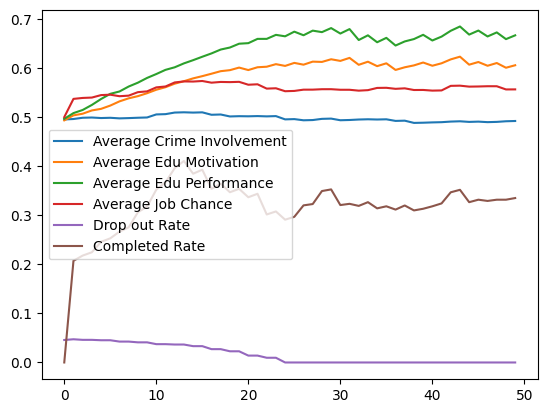

In [34]:
model_data.plot()
plt.show()